In [1]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
import time
from einops import rearrange
from tqdm import tqdm
import torch
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import rasterio
import spectral

from utils import Metric,get_model_size,test_speed, set_logger,init_weights,set_seed, save_checkpoint, load_checkpoint
from models.KANFormer import KANFormer
from utils import get_model_size
from data import ChikuseiDataset

%load_ext autoreload
%autoreload 2

In [2]:
# Specify the path to the ENVI data file and the file with .hdr
file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.bsq'
header_file = '/mnt/c/data/chikusei_ENVI/HyperspecVNIR_Chikusei_20140729.hdr'

# Open the ENVI image using rasterio
with rasterio.open(file) as src:
    # Read the hyperspectral data into a NumPy array
    print("Reading HS data")
    hyperspectral_data = src.read()

    # Display information about the hyperspectral data
    print('Shape of hyperspectral data:', hyperspectral_data.shape)
    print('Number of bands:', src.count)

Reading HS data
Shape of hyperspectral data: (128, 2517, 2335)
Number of bands: 128


15133


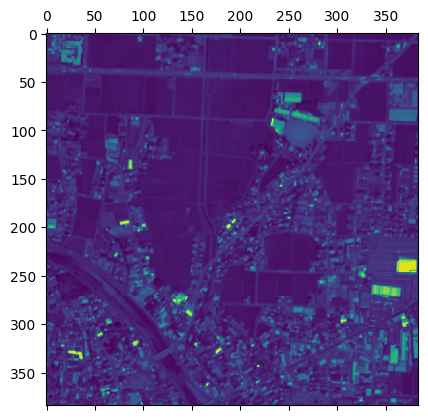

In [3]:
print(np.max(hyperspectral_data))
plt.matshow(hyperspectral_data[32,128:512,128:512])
plt.show()

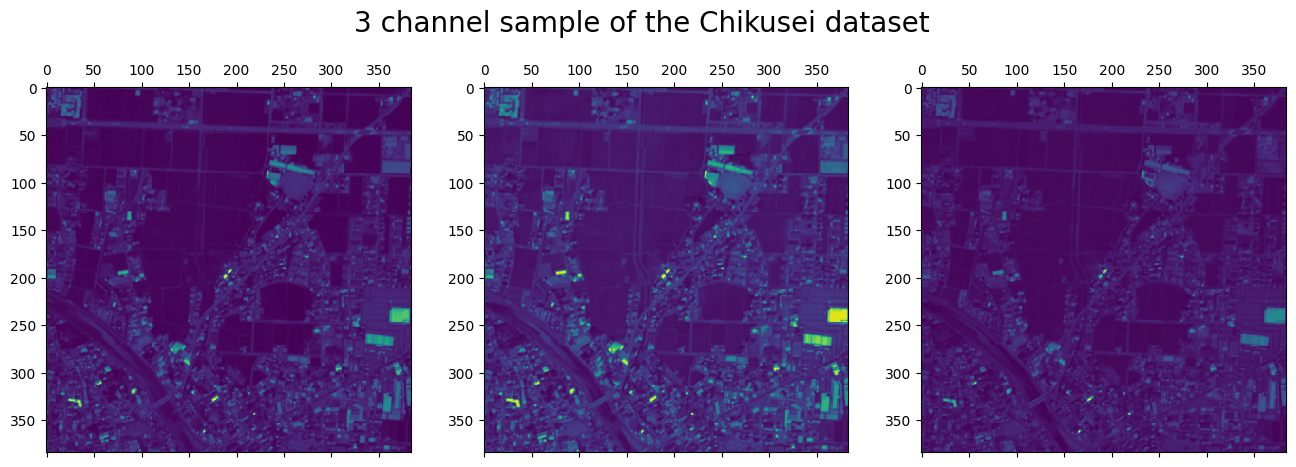

In [13]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(16,8))
fig.suptitle('3 channel sample of the Chikusei dataset ', fontsize=20, y=0.98)
ax[0].matshow(hyperspectral_data[16,128:512,128:512])
ax[1].matshow(hyperspectral_data[32,128:512,128:512])
ax[2].matshow(hyperspectral_data[64,128:512,128:512])
fig.subplots_adjust(top=1.2) 
plt.show()

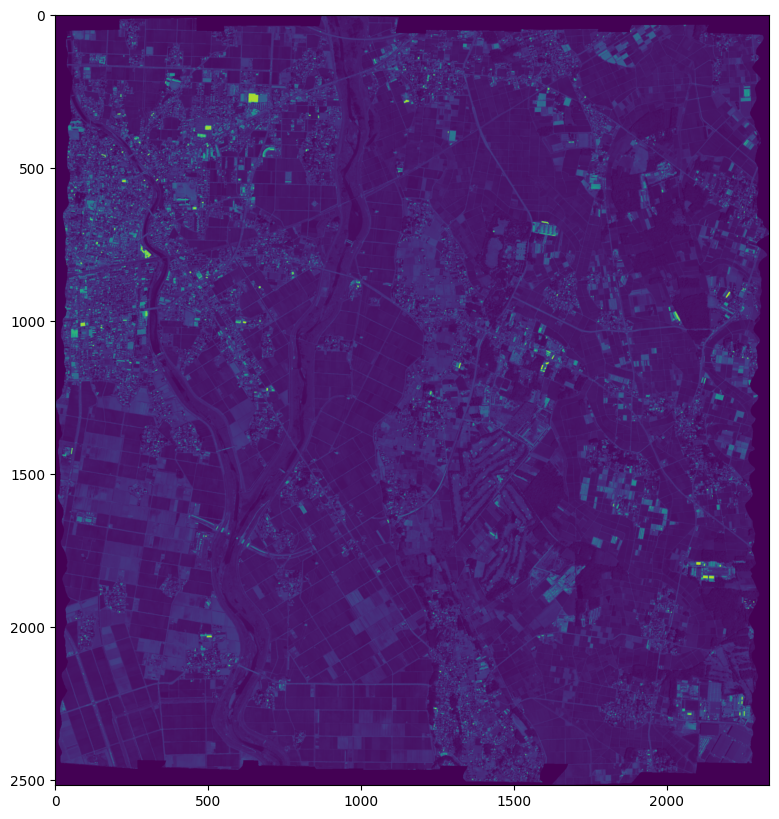

dtype('int16')

In [15]:
full_image = rearrange(hyperspectral_data,'c h w -> h w c')
plt.figure(figsize=(10,10))
plt.imshow(full_image[:,:,32])
plt.show()
full_image.dtype

In [14]:
#Open the image with spectral
header_spectral = spectral.open_image(header_file)

# Access the wavelengths associated with each band
w_vector = np.array(header_spectral.bands.centers)

# Display information about the hyperspectral data and wavelengths
print('Shape of hyperspectral data:', header_spectral.shape)
print('Number of bands:', header_spectral.shape[2])
print('Wavelengths:', w_vector)

Shape of hyperspectral data: (2517, 2335, 128)
Number of bands: 128
Wavelengths: [0.36259 0.36775 0.3729  0.37807 0.38323 0.38839 0.39355 0.39871 0.40387
 0.40903 0.41419 0.41936 0.42452 0.42968 0.43484 0.44    0.44516 0.45032
 0.45548 0.46064 0.4658  0.47096 0.47612 0.48129 0.48645 0.49161 0.49677
 0.50193 0.50709 0.51225 0.51741 0.52257 0.52773 0.53289 0.53806 0.54321
 0.54838 0.55354 0.5587  0.56386 0.56902 0.57418 0.57934 0.5845  0.58966
 0.59483 0.59999 0.60514 0.61031 0.61547 0.62063 0.62579 0.63095 0.63611
 0.64127 0.64643 0.65159 0.65675 0.66192 0.66707 0.67224 0.6774  0.68256
 0.68772 0.69288 0.69804 0.7032  0.70836 0.71352 0.71868 0.72385 0.72901
 0.73417 0.73933 0.74449 0.74965 0.75481 0.75997 0.76513 0.77029 0.77545
 0.78061 0.78578 0.79094 0.7961  0.80126 0.80642 0.81158 0.81674 0.8219
 0.82706 0.83223 0.83738 0.84254 0.84771 0.85287 0.85803 0.86319 0.86835
 0.87351 0.87867 0.88383 0.88899 0.89416 0.89931 0.90448 0.90964 0.9148
 0.91996 0.92512 0.93028 0.93544 0.9406  0.94

# Model testing post-training

## Single image fusion

In [18]:
# Model instantiation
# full_image = rearrange(hyperspectral_data,'c h w -> h w c')
HSI_bands = full_image.shape[2]
MSI_bands = 4
trained_chikusei_KAN = KANFormer(HSI_bands=HSI_bands,MSI_bands=MSI_bands,hidden_dim=256,scale=4,depth=4,image_size=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_chikusei_KAN = trained_chikusei_KAN.to(device)

checkpoint_model_path = 'trained_models/KANFormer_x4/KANFormer_x4.pth'

# state_list = ['epoch', 'model', 'optimizer', 'scheduler', 'hist_batch_loss', 'hist_epoch_loss']
# Model loading
checkpoint = torch.load(checkpoint_model_path)
trained_chikusei_KAN.load_state_dict(checkpoint['model'],strict=False)
hist_batch_loss = checkpoint['hist_batch_loss']
hist_epoch_loss = checkpoint['hist_epoch_loss']
print(len(hist_epoch_loss))

4
4
1200


/tmp/ipykernel_1070/129321012.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_model_path)


In [19]:
# Datasets
chikusei_data_training = ChikuseiDataset(full_image=full_image,training_zone=[128,128,1024,1024],wave_vector=w_vector,device=device,scale=4,gt_size=64)
chikusei_data_test = ChikuseiDataset(full_image=full_image,training_zone=[1183,1365,2335,2517],wave_vector=w_vector,device=device,scale=4,gt_size=64)
# chikusei_data_full = ChikuseiDataset(full_image=full_image,training_zone=[0,0,2335,2517],wave_vector=w_vector,device=device,scale=4,gt_size=64)

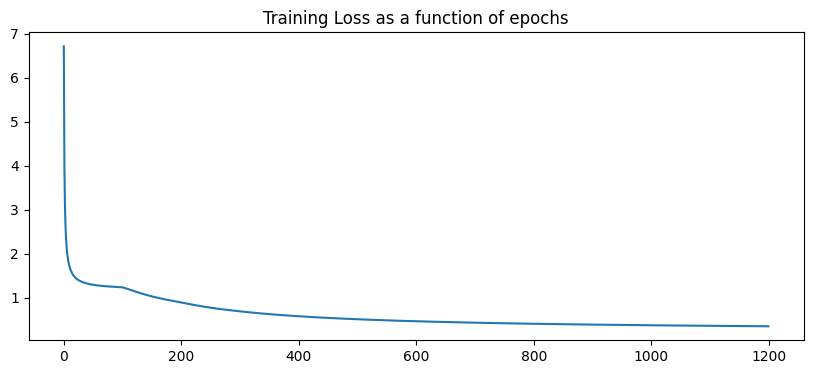

In [20]:
plt.figure(figsize=(10,4))
plt.plot(hist_epoch_loss)
plt.title('Training Loss as a function of epochs')
plt.show()

### Fusion on training data

In [31]:
# On training set
train_image_sample = chikusei_data_test.__getitem__(12)
gt = train_image_sample[0]
print(f"GT shape {gt.shape}")
lrhs =  train_image_sample[1]
print(f"LR shape  {lrhs.shape}")
hrms = train_image_sample[2]
print(f"HR shape {hrms.shape}")
gt.requires_grad_(False)
lrhs.requires_grad_(False)
hrms.requires_grad_(False)
0

GT shape torch.Size([128, 64, 64])
LR shape  torch.Size([128, 16, 16])
HR shape torch.Size([4, 64, 64])


0

In [32]:
c, h, w = tuple(gt.shape)
with torch.no_grad():
    trained_chikusei_KAN.eval()
    fused = trained_chikusei_KAN.forward(lrhs.reshape(1,c,16,16),hrms.reshape(1,4,h,w))
fused_image = fused.cpu().detach().numpy()

In [33]:
print(fused_image.shape)
print(fused_image.dtype)
fused_image = rearrange(fused_image,'b c h w -> h w c b')
print(fused_image.shape)

(1, 128, 64, 64)
float32
(64, 64, 128, 1)


In [34]:
gt_image = gt.cpu().detach().numpy()
gt_image = rearrange(gt_image,'c h w -> h w c')

In [35]:
print(gt_image.shape)
print(fused_image.shape)

(64, 64, 128)
(64, 64, 128, 1)


In [36]:
np.sum(gt_image-fused_image[:,:,:,0])

np.float32(1570.623)

### Metrics on training data fusion

In [ ]:
from utils import Metric

# Compute predictions on training set and metrics
c, h, w = tuple(chikusei_data_training.GT_tensor_list[0].shape)
metrics_list = []
with torch.no_grad():
   trained_chikusei_KAN.eval()
   #  lrhs_batched = torch.stack(chikusei_data_test.LRHSI_tensor_list)
   #  hrms_batched = torch.stack(chikusei_data_test.HRMSI_tensor_list)
   for i in range(chikusei_data_test.dataset_size):
      lrhs_batched = chikusei_data_training.LRHSI_tensor_list[i].reshape((1,c,16,16))
      hrms_batched = chikusei_data_training.HRMSI_tensor_list[i].reshape((1,4,h,w))
      fused_tensor = torch.squeeze(trained_chikusei_KAN.forward(lrhs_batched,hrms_batched))
      metrics = Metric(chikusei_data_training.GT_tensor_list[i],fused_tensor)
      metrics_list.append(metrics.get_metrics())

metrics_list

[{'PSNR': np.float32(33.78927),
  'RMSE': np.float32(0.020442626),
  'SAM': np.float32(2.89472),
  'ERGAS': np.float32(2.3225465),
  'SSIM': np.float64(0.9847947498734272)},
 {'PSNR': np.float32(34.67508),
  'RMSE': np.float32(0.01846061),
  'SAM': np.float32(2.9291162),
  'ERGAS': np.float32(2.9363198),
  'SSIM': np.float64(0.9795962263505248)},
 {'PSNR': np.float32(33.69753),
  'RMSE': np.float32(0.020659681),
  'SAM': np.float32(2.4893851),
  'ERGAS': np.float32(2.3311398),
  'SSIM': np.float64(0.9824679734940222)},
 {'PSNR': np.float32(34.336082),
  'RMSE': np.float32(0.019195342),
  'SAM': np.float32(2.8694298),
  'ERGAS': np.float32(2.6975303),
  'SSIM': np.float64(0.9809857806518094)},
 {'PSNR': np.float32(35.68653),
  'RMSE': np.float32(0.016431356),
  'SAM': np.float32(2.5448246),
  'ERGAS': np.float32(2.2282336),
  'SSIM': np.float64(0.988525488344794)},
 {'PSNR': np.float32(35.322502),
  'RMSE': np.float32(0.017134633),
  'SAM': np.float32(2.1611087),
  'ERGAS': np.float32(2

In [64]:
def get_average_metrics(m_list: list) -> dict:
   average_metrics = {}
   keys = m_list[0].keys()
   get_average = lambda m_list, key: (sum(m[key] for m in m_list) / len(m_list)).item()
   for k in keys:
      average_metrics[k] = get_average(m_list,k)
   print(f"Average metrics on training/test set {average_metrics}")
   return(average_metrics)


In [ ]:
get_average_metrics(metrics_list)

{'PSNR': 35.50582504272461,
 'RMSE': 0.01735641248524189,
 'SAM': 2.7265567779541016,
 'ERGAS': 2.4557623863220215,
 'SSIM': 0.9842030140957139}

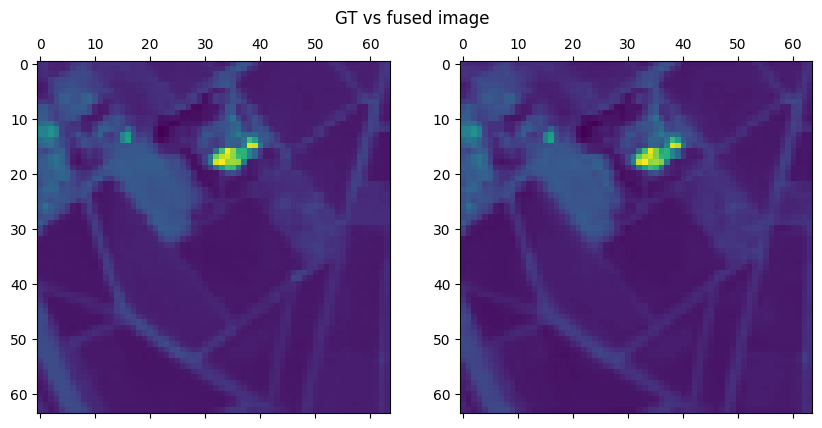

In [37]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
ax[0].matshow(gt_image[:,:,64])
ax[1].matshow(fused_image[:,:,64,0])
fig.suptitle("GT vs fused image")
fig.subplots_adjust(top=1.2)
plt.show()

### Fusion on test data

In [48]:
first_test_image_set = chikusei_data_test.__getitem__(12)
gt = first_test_image_set[0]
print(f"GT shape {gt.shape}")
lrhs =  first_test_image_set[1]
print(f"LR shape  {lrhs.shape}")
hrms = first_test_image_set[2]
print(f"HR shape {hrms.shape}")

GT shape torch.Size([128, 64, 64])
LR shape  torch.Size([128, 16, 16])
HR shape torch.Size([4, 64, 64])


In [49]:
gt_image = gt.cpu().detach().numpy()  

In [50]:
c, h, w = tuple(gt.shape)
with torch.no_grad():
    trained_chikusei_KAN.eval()
    fused = trained_chikusei_KAN.forward(lrhs.reshape(1,c,16,16),hrms.reshape(1,4,h,w))
fused_image = fused.cpu().detach().numpy()
print(fused_image.shape)
print(type(fused_image))
fused_image = rearrange(fused_image,'b c h w -> h w c b')
print(fused_image.shape)

(1, 128, 64, 64)
<class 'numpy.ndarray'>
(64, 64, 128, 1)


In [64]:
print(fused_image.shape)

(64, 64, 128, 1)


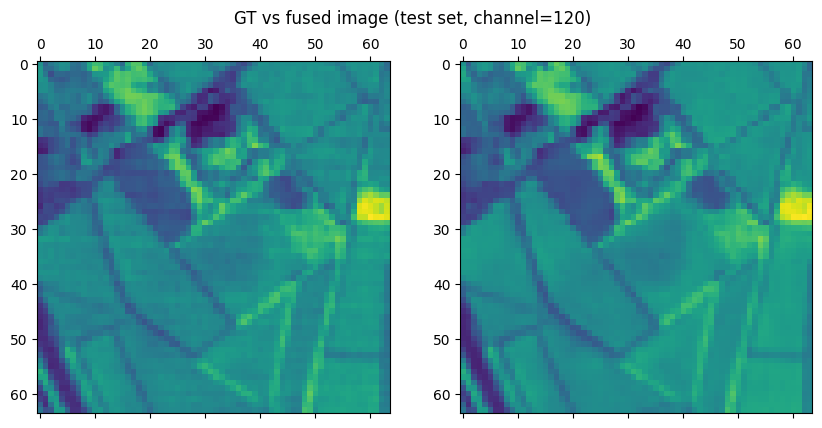

In [52]:
gt_image = gt.cpu().detach().numpy()    
gt_image = rearrange(gt_image,'c h w -> h w c')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7))
channel = 120
ax[0].matshow(gt_image[:,:,channel])
ax[1].matshow(fused_image[:,:,channel,0])
fig.suptitle(f"GT vs fused image (test set, channel={channel})")
fig.subplots_adjust(top=1.2)
plt.show()

(64, 64, 128)


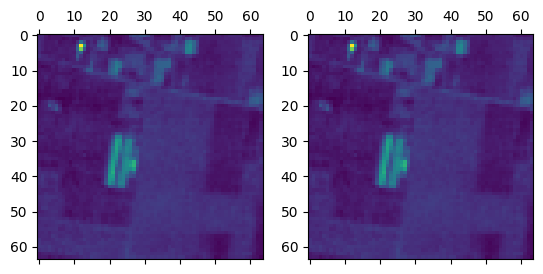

In [66]:
[1183,1365,2335,2517]
# Debugging

i_range = 14
j_range = 14
gt_size = 64
GT_list = []
x0 = 1183
y0 = 1365
i = 0
j = 0
target_zone = full_image[y0+i*gt_size:y0+(i+1)*gt_size,x0+j*gt_size:x0+(j+1)*gt_size,:].astype(np.float32)

print(target_zone.shape)

gt_image = gt.cpu().detach().numpy()    
gt_image = rearrange(gt_image,'c h w -> h w c')
fig, ax = plt.subplots(nrows=1, ncols=2)
channel = 3
ax[0].matshow(gt_image[:,:,channel])
ax[1].matshow(target_zone[:,:,channel])
plt.show()

### Metrics on test set

In [48]:
# Reimport model
# Model instantiation
# full_image = rearrange(hyperspectral_data,'c h w -> h w c')
HSI_bands = full_image.shape[2]
MSI_bands = 4
trained_chikusei_KAN = KANFormer(HSI_bands=HSI_bands,MSI_bands=MSI_bands,hidden_dim=256,scale=4,depth=4,image_size=64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_chikusei_KAN = trained_chikusei_KAN.to(device)

checkpoint_model_path = 'trained_models/KANFormer_x4/KANFormer_x4.pth'

# state_list = ['epoch', 'model', 'optimizer', 'scheduler', 'hist_batch_loss', 'hist_epoch_loss']
# Model loading
checkpoint = torch.load(checkpoint_model_path)
trained_chikusei_KAN.load_state_dict(checkpoint['model'],strict=False)
hist_batch_loss = checkpoint['hist_batch_loss']
hist_epoch_loss = checkpoint['hist_epoch_loss']
print(f"Model trained on {len(hist_epoch_loss)} epochs")

# Redefine training and test sets
chikusei_data_training_larger = ChikuseiDataset(full_image=full_image,training_zone=[128,128,2176,1332],wave_vector=w_vector,device=device,scale=4,gt_size=64)
chikusei_data_test_larger = ChikuseiDataset(full_image=full_image,training_zone=[128,1493,2176,2517],wave_vector=w_vector,device=device,scale=4,gt_size=64)

4
4


/tmp/ipykernel_908/2637016410.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_model_path)


Model trained on 1200 epochs


In [58]:
from utils import Metric

# Compute predictions on training set and metrics
c, h, w = tuple(chikusei_data_training_larger.GT_tensor_list[0].shape)
metrics_train_list = []
with torch.no_grad():
   trained_chikusei_KAN.eval()
   for i in range(chikusei_data_training_larger.dataset_size):
      lrhs_batched = chikusei_data_training_larger.LRHSI_tensor_list[i].reshape((1,c,16,16))
      hrms_batched = chikusei_data_training_larger.HRMSI_tensor_list[i].reshape((1,4,h,w))
      fused_tensor = torch.squeeze(trained_chikusei_KAN.forward(lrhs_batched,hrms_batched))
      metrics = Metric(chikusei_data_training_larger.GT_tensor_list[i],fused_tensor)
      metrics_train_list.append(metrics.get_metrics())

# Compute predictions on test set and metrics
c, h, w = tuple(chikusei_data_test_larger.GT_tensor_list[0].shape)
metrics_test_list = []
with torch.no_grad():
   trained_chikusei_KAN.eval()
   for i in range(chikusei_data_test_larger.dataset_size-2):
      lrhs_batched = chikusei_data_test_larger.LRHSI_tensor_list[i].reshape((1,c,16,16))
      hrms_batched = chikusei_data_test_larger.HRMSI_tensor_list[i].reshape((1,4,h,w))
      fused_tensor = torch.squeeze(trained_chikusei_KAN.forward(lrhs_batched,hrms_batched))
      metrics = Metric(chikusei_data_test_larger.GT_tensor_list[i],fused_tensor)
      metrics_test_list.append(metrics.get_metrics())


In [59]:
metrics_test_list[-4:]

[{'PSNR': np.float32(32.90111),
  'RMSE': np.float32(0.02264354),
  'SAM': np.float32(2.5730872),
  'ERGAS': np.float32(2.6212423),
  'SSIM': np.float64(0.9693601401762572)},
 {'PSNR': np.float32(34.075676),
  'RMSE': np.float32(0.01977954),
  'SAM': np.float32(3.377349),
  'ERGAS': np.float32(2.6662745),
  'SSIM': np.float64(0.9618424307328268)},
 {'PSNR': np.float32(34.641125),
  'RMSE': np.float32(0.018532917),
  'SAM': np.float32(1.7583674),
  'ERGAS': np.float32(5.17686),
  'SSIM': np.float64(0.9778691673125546)},
 {'PSNR': np.float32(33.342464),
  'RMSE': np.float32(0.021521714),
  'SAM': np.float32(1.4945984),
  'ERGAS': np.float32(4.930711),
  'SSIM': np.float64(0.9728341733218973)}]

In [60]:
len(metrics_train_list)

576

In [65]:
get_average_metrics(metrics_test_list)

Average metrics on training/test set {'PSNR': 32.31752395629883, 'RMSE': 0.025099461898207664, 'SAM': 3.309180498123169, 'ERGAS': 3.5339696407318115, 'SSIM': 0.9621128312986458}


{'PSNR': 32.31752395629883,
 'RMSE': 0.025099461898207664,
 'SAM': 3.309180498123169,
 'ERGAS': 3.5339696407318115,
 'SSIM': 0.9621128312986458}

In [66]:
get_average_metrics(metrics_train_list)

Average metrics on training/test set {'PSNR': 33.51617431640625, 'RMSE': 0.022210534662008286, 'SAM': 3.2777204513549805, 'ERGAS': 2.8762810230255127, 'SSIM': 0.9727935680665146}


{'PSNR': 33.51617431640625,
 'RMSE': 0.022210534662008286,
 'SAM': 3.2777204513549805,
 'ERGAS': 2.8762810230255127,
 'SSIM': 0.9727935680665146}

#### Results from paper (trained on double the size)
PSNR SAM ERGAS SSIM
37.42 1.87 3.31 0.968

## First model (1024x1024, gamma = 0.2)
#### Results for training set
{'PSNR': 35.50582504272461,
 'RMSE': 0.01735641248524189,
 'SAM': 2.7265567779541016,
 'ERGAS': 2.4557623863220215,
 'SSIM': 0.9842030140957139}
#### Results for test set
{'PSNR': 32.510826110839844,
 'RMSE': 0.024655962362885475,
 'SAM': 3.5118565559387207,
 'ERGAS': 3.9368858337402344,
 'SSIM': 0.9647864811207322}

 ## Second model (1024x2048, gamma = 0.1)
#### Results for training set
{'PSNR': 33.51617431640625,
 'RMSE': 0.022210534662008286,
 'SAM': 3.2777204513549805,
 'ERGAS': 2.8762810230255127,
 'SSIM': 0.9727935680665146}
 #### Results for test set
{'PSNR': 32.31752395629883,
 'RMSE': 0.025099461898207664,
 'SAM': 3.309180498123169,
 'ERGAS': 3.5339696407318115,
 'SSIM': 0.9621128312986458}


#### Testing with larger patches NOT COMPATIBLE WITH TRAINED MODEL!

In [12]:
chikusei_data_test_larger = ChikuseiDataset(full_image=full_image,training_zone=[1183,0,2335,1152],wave_vector=w_vector,device=device,scale=4,gt_size=128)

In [ ]:
c, h, w = tuple(chikusei_data_test_larger.GT_tensor_list[0].shape)
metrics_list = []
with torch.no_grad():
   trained_chikusei_KAN.eval()
   for i in range(chikusei_data_test_larger.dataset_size):
      lrhs_batched = chikusei_data_test_larger.LRHSI_tensor_list[i].reshape((1,c,16,16))
      hrms_batched = chikusei_data_test_larger.HRMSI_tensor_list[i].reshape((1,4,h,w))
      fused_tensor = torch.squeeze(trained_chikusei_KAN.forward(lrhs_batched,hrms_batched))
      metrics = Metric(chikusei_data_test.GT_tensor_list[i],fused_tensor)
      metrics_list.append(metrics.get_metrics())